In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from scipy.linalg import cholesky, solve_triangular

from modmcmc import State, BlockMCMCSampler, LogDensityTerm, TargetDensity
from modmcmc.kernels import MarkovKernel, GaussMetropolisKernel, DiscretePCNKernel, mvn_logpdf
import modmcmc as mm
from Gaussian import Gaussian
from helper import get_col_hist_grid, plot_trace, get_cpm_sampler, get_approx_mwg_sampler, run_sampler
from helper import get_naive_cut_sampler, get_cut_pcn_sampler, get_ep_rv, get_eup_rv, direct_sample_ep

In [2]:
rng = np.random.default_rng(532124)

# Set up linear Gaussian inverse problem and forward model emulator

In [3]:
# Linear Gaussian inverse problem

# Parameter and observation dimension
d = 2
n = 20

# Prior
m = rng.normal(size=d)
C_sqrt = rng.normal(size=(d,d))
C = C_sqrt @ C_sqrt.T
u = Gaussian(mean=m, cov=C, rng=rng)

# Linear forward model
G = rng.normal(size=(n,d))

# Noise covariance
Sig_sqrt = rng.normal(size=(n,n))
Sig = Sig_sqrt @ Sig_sqrt.T
noise = Gaussian(cov=Sig, rng=rng, store="both")

# Data
y = G @ u.sample() + noise.sample()

In [4]:
# Forward model emulator of the form f_star(u) = f(u) + e, e ~ N(r, Q)
q_scale = 0.2
r = rng.normal(size=n)
Q_sqrt = q_scale * rng.normal(size=(n,n))
Q = Q_sqrt @ Q_sqrt.T
e = Gaussian(mean=r, cov=Q, rng=rng)

# Comparing EP and EUP

In [5]:
u_post = u.invert_affine_Gaussian(y, A=G, cov_noise=noise.cov)
u_ep = get_ep_rv(y, u, G, noise, e)
u_eup = get_eup_rv(y, u, G, noise, e)

In [6]:
n_samp = 100000
samp_post = u_post.sample(n_samp)
samp_ep = u_ep.sample(n_samp)
samp_eup = u_eup.sample(n_samp)
# samp_ep2 = direct_sample_ep(y, u, G, Sig, e, n_samp)

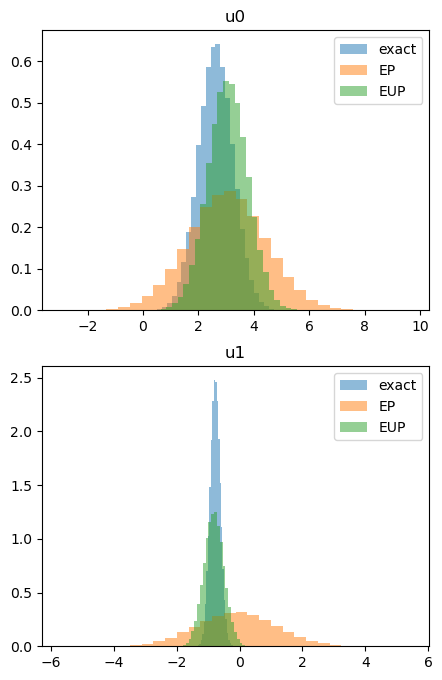

In [7]:
col_labs=[f"u{i}" for i in range(d)]
plot_labs = ["exact", "EP", "EUP"] #, "EP2"]

hist_plt = get_col_hist_grid(samp_post, samp_ep, samp_eup, bins=30, nrows=2, 
                             col_labs=col_labs, plot_labs=plot_labs)
plt.show()

# Compare exact EP vs MCMC-based approximations

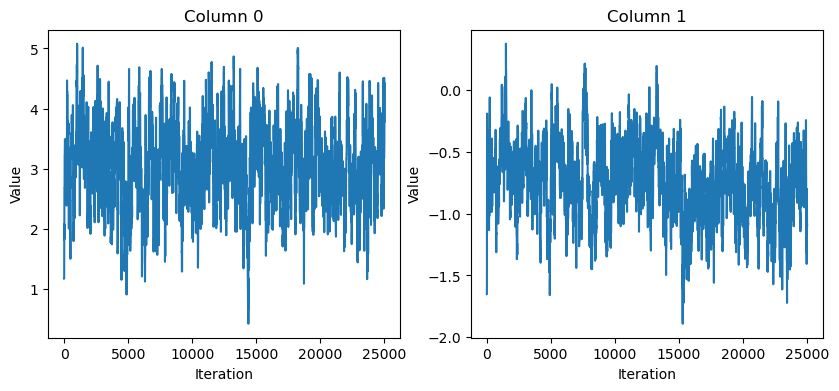

In [8]:
# Correlated pseudo marginal
cpm = get_cpm_sampler(y, u, G, noise, e, rng, pcn_cor=0.99)
samp_cpm, cpm, trace_cpm = run_sampler(cpm)
plt.show()

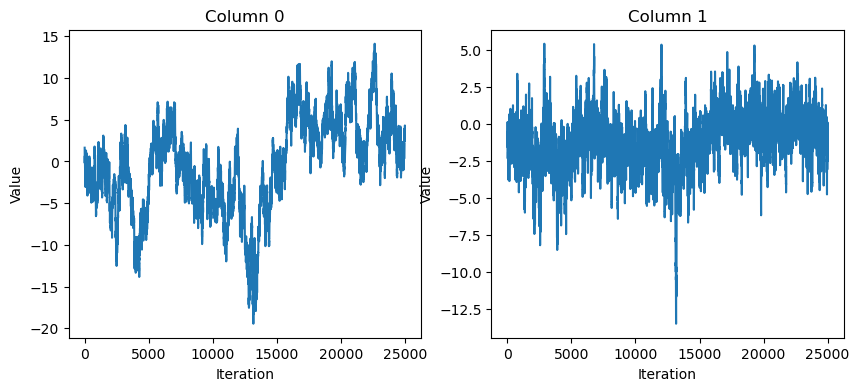

In [9]:
# Naive cut
cut_alg = get_naive_cut_sampler(y, u, G, noise, e, rng, u_prop_scale=0.1)
samp_cut, cut_alg, trace_cut = run_sampler(cut_alg)
plt.show()

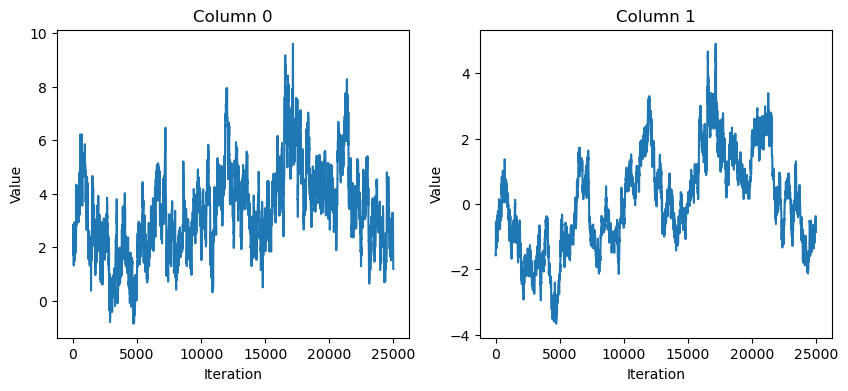

In [10]:
# Approximate Metropolis-within-Gibbs (with naive normalizing constant estimation)
mwg = get_approx_mwg_sampler(y, u, G, noise, e, rng, pcn_cor=0.99)
samp_mwg, mwg, trace_mwg = run_sampler(mwg)
plt.show()

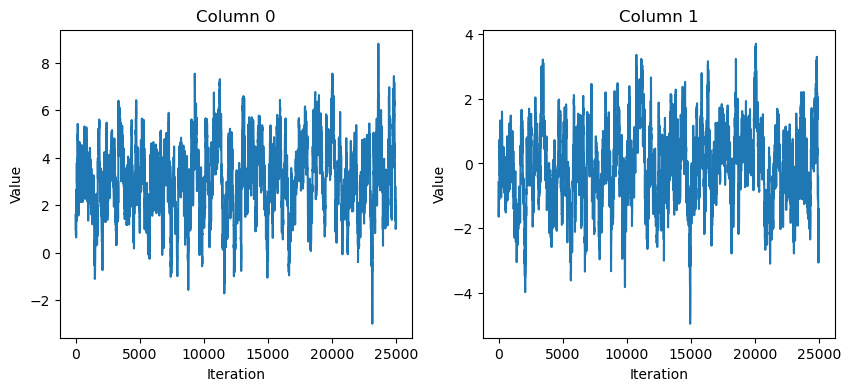

In [11]:
# Cut pCN algorithm.
cut_pcn = get_cut_pcn_sampler(y, u, G, noise, e, rng, pcn_cor=0.99)
samp_cut_pcn, cut_pcn, trace_cut_pcn = run_sampler(cut_pcn)
plt.show()

## Comparison

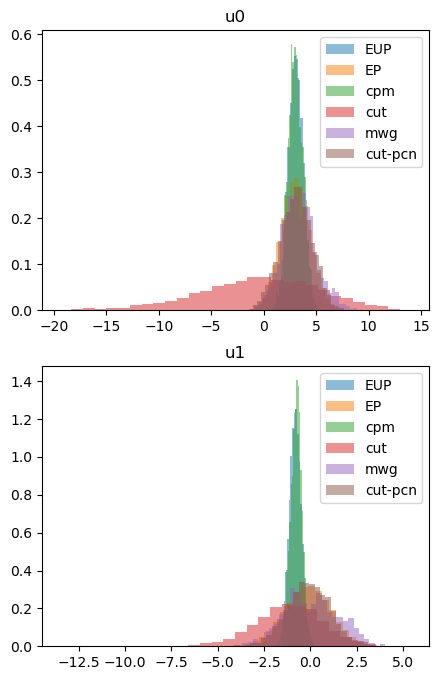

In [13]:
hist_plt_mcmc = get_col_hist_grid(samp_eup, samp_ep, samp_cpm, samp_cut, samp_mwg, samp_cut_pcn, bins=30, nrows=1, 
                                  col_labs=col_labs, plot_labs=["EUP", "EP", "cpm", "cut", "mwg", "cut-pcn"])
plt.show()

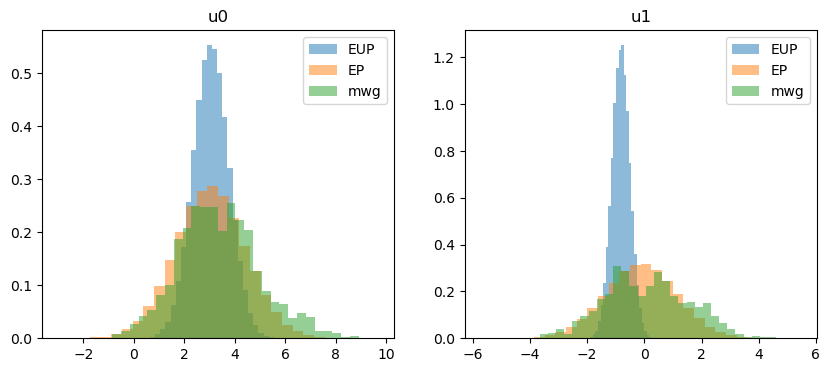

In [15]:
hist_plt_mwg = get_col_hist_grid(samp_eup, samp_ep, samp_mwg, bins=30, nrows=1, 
                                 col_labs=col_labs, plot_labs=["EUP", "EP", "mwg"])
plt.show()

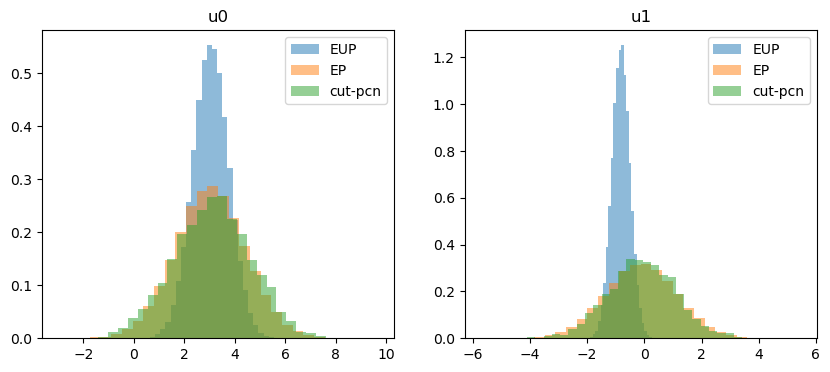

In [16]:
hist_plt_cut_pcn = get_col_hist_grid(samp_eup, samp_ep, samp_cut_pcn, bins=30, nrows=1, 
                                     col_labs=col_labs, plot_labs=["EUP", "EP", "cut-pcn"])
plt.show()